# Lab Five: Wide and Deep Network Architectures

# James Thomas, Xiaoxian Jing, Kuang Yan

 1. [Dataset Selection](#data)<br>
 2. [Preparation](#prep)<br>
  2.1 [Define Class Variables](#class_variables)<br>
  2.2 [Cross-Product-Features](#cross_product_features)<br>
  2.3 [Metric](#metric)<br>
  3.4 [Test-Train Split](#split)<br>
 3. [Modeling](#modeling)<br>
  3.1 [Classify Using Keras](#keras)<br>
  3.2 [Generalization Performance](#generalization)<br>
  3.3 [Compare to Multi-Layer Perceptron](#compare)<br>
 4. [Exceptional Work](#exceptional)<br>
  4.1 [Additional Analysis](#additional_analysis)<br>
  4.2 [Embedded Weights](#embedded_weights)<br>
 5. [Final Thoughts](#thoughts)<br>
  
[//]: # (put the html anchors above the titles for better scrolling)
[//]: # (note the <br>, and why do I need .. for 3rd level?, maybe I should just use pureish html)

<a id="data"></a>
## Dataset Selection
Select a dataset identically to the way you selected for lab one or lab three (table data or image data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains __three or more classes__ to predict. That is, it cannot be a binary classification; it must be multi-class prediction. 

<a id="prep"></a>
## Preparation __(40 points total)__

<a id="class_variables"></a>
### Define Class Variables

> __[10 points]__ Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification (include a description of any newly formed variables you created).

In [1]:
# load the full dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.style.use('ggplot')
%matplotlib inline

full_df = pd.read_csv('data/diabetic_data.csv')

full_df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

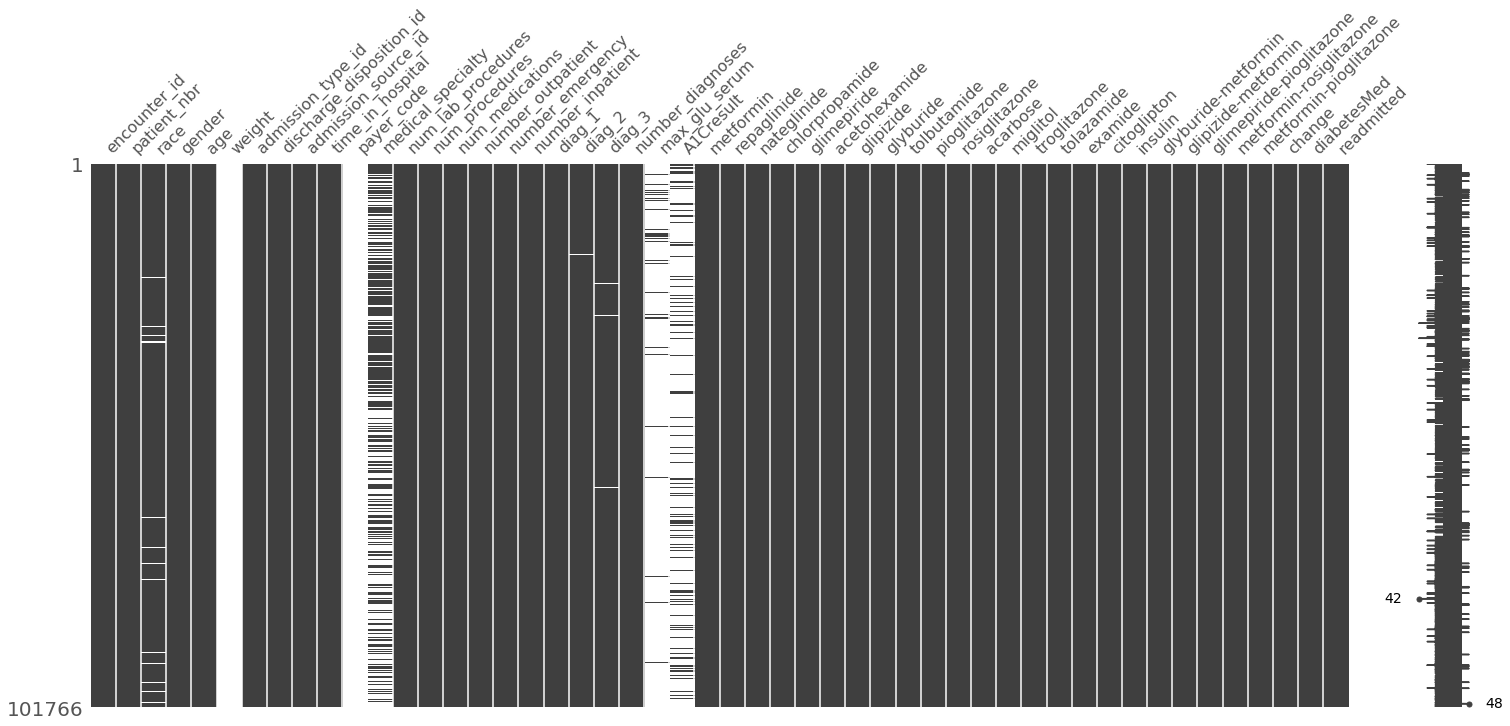

In [3]:
# now convert columns that should be numeric to numeric types,

import os
if os.getcwd().find('jamesthomas'):
    import sys
    sys.path.append('/users/jamesthomas/python_packages/')
    import missingno as mn
        
# first force the columns that should be numeric to numeric
numeric_cols = ['weight','payer_code']
full_df[numeric_cols]=full_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# now replace the '?' in the string data
full_df.replace({'?':None,'None':None}, inplace = True)
mn.matrix(full_df)

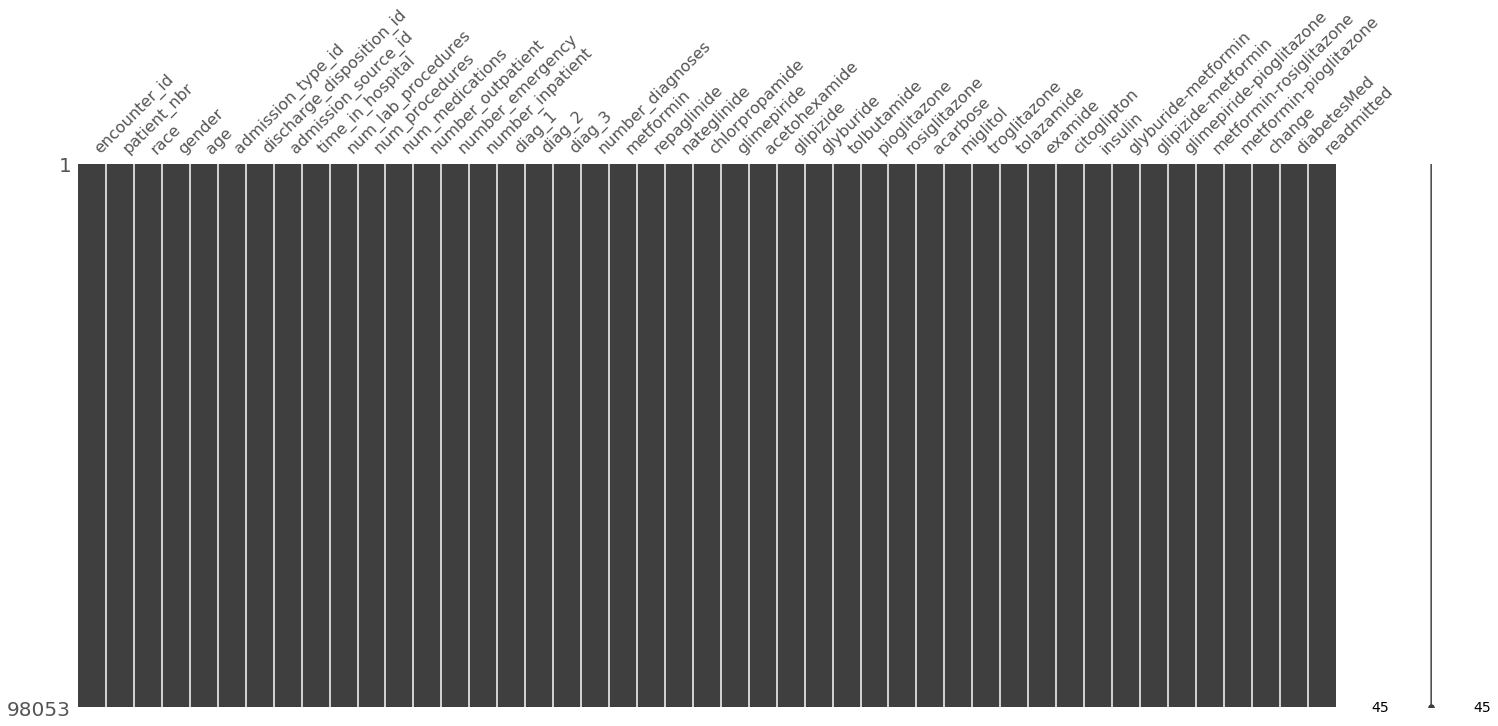

In [4]:
# then drop the columns missing too much data and then the rows with any missing data. 

cols = list(full_df)
datas = list(full_df.isnull().sum())
size = full_df.shape[0]
drop_cols = []
threshold = 0.08
for i in range(len(cols)):
    if datas[i]/size > threshold:
        drop_cols.append(cols[i])

full_df.drop(drop_cols, axis=1, inplace=True)
full_df.dropna(inplace=True)

mn.matrix(full_df)

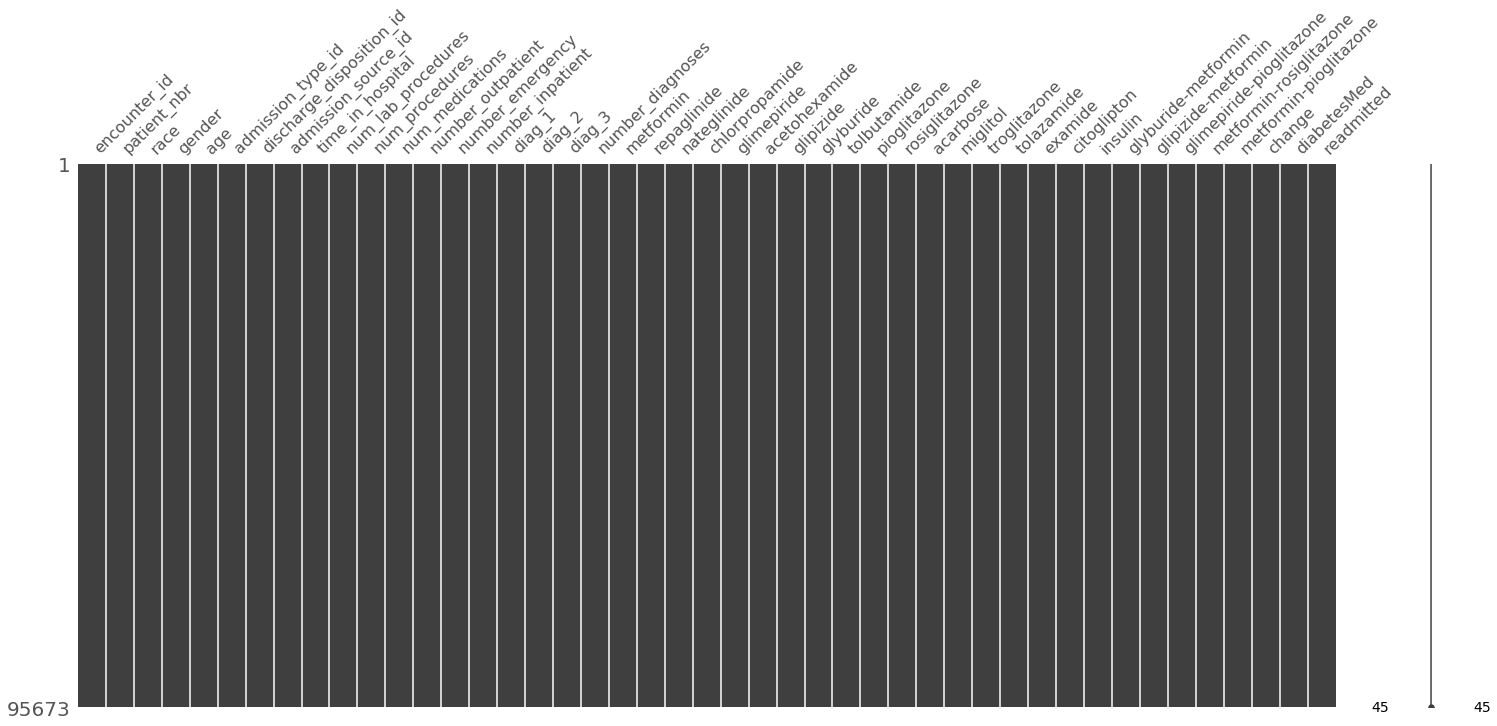

In [5]:
# now drop some rows based on discharge disposition
discharge_disp_ids = [11, 13, 14, 19, 20, 21]
full_df = full_df.loc[~full_df.discharge_disposition_id.isin(discharge_disp_ids)]
mn.matrix(full_df)

In [6]:
# some helper functions for data conversion
def one_hot_encode(df, column):
    '''If the column only contains a single value, there is no information so don't do anything,
    otherwise one hot encode the column
    '''
    col_names = []
    if len(df[col].unique()) != 1:
        # more than one value in category
        df[column] = pd.Categorical(df[column])
        dfDummies = pd.get_dummies(df[column], prefix = column+'_category', drop_first=True) # added drop_first
        col_names.append(list(dfDummies))
        df = pd.concat([df, dfDummies], axis=1)
    return df, col_names

def diag_categorize(val):
    '''More information about the categories can be found at http://www.icd9data.com/
    '''
    try:
        val = float(val)
        if val < 140:
            return('Infectious and Parasitic Disease')
        elif val < 240:
            return('Neoplasms')
        elif val < 280:
            return('Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders')
        elif val < 290:
            return('Diseases Of The Blood And Blood-Forming Organs')
        elif val < 320:
            return('Mental Disorders')
        elif val < 390:
            return('Diseases Of The Nervous System And Sense Organs')
        elif val < 460:
            return('Diseases Of The Circulatory System')
        elif val < 520:
            return('Diseases Of The Circulatory System')
        elif val < 580:
            return('Diseases Of The Digestive System')
        elif val < 630:
            return('Diseases Of The Genitourinary System')
        elif val < 680:
            return('Complications Of Pregnancy, Childbirth, And The Puerperium')
        elif val < 710:
            return('Diseases Of The Skin And Subcutaneous Tissue')
        elif val < 740:
            return('Diseases Of The Musculoskeletal System And Connective Tissue')
        elif val < 760:
            return('Congenital Anomalies')
        elif val < 780:
            return('Certain Conditions Originating In The Perinatal Period')
        elif val < 800:
            return('Symptoms, Signs, And Ill-Defined Conditions')
        else:
            return('Injury And Poisoning')
    except:
        if val[0]=='V':
            return('Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services')
        elif val[0]=='E':
            return('Supplementary Classification Of External Causes Of Injury And Poisoning')
        else:
            print(val)
            return(None)

In [7]:
# these are the columns that use the ICD9 data

explain_list = ['diag_1', 'diag_2', 'diag_3']
for diag in explain_list:
    full_df[diag+'_explain'] = full_df[diag].apply(diag_categorize)

In [8]:
# these are the columns that need one hot encoded

one_hot_encode_list = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide',
                       'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone',
                       'tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin',
                       'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone',
                       'diag_1_explain','diag_2_explain','diag_3_explain','race','admission_type_id',
                       'discharge_disposition_id','admission_source_id','insulin']

# the names are so we don't use standard scalar on one hot encoded columns
one_hot_encoded_names = []
for col in one_hot_encode_list:
    full_df, one_hot_names = one_hot_encode(full_df, col)
    one_hot_encoded_names.append(one_hot_names)

full_df.drop(one_hot_encode_list+explain_list, axis=1, inplace=True)

In [9]:
# Now we will convert the 'patient_nbr' column to a new column that shows counts how many times the patient visitied
# the hospital in the study

full_df['freq'] = full_df.groupby('patient_nbr')['patient_nbr'].transform('count')

In [10]:
# these are the columns that are no longer relevant, either because we transformed the data or it is just an id

drop_not_relevant = ['encounter_id', 'patient_nbr']
full_df.drop(drop_not_relevant, axis=1, inplace=True)

In [11]:
# now label encoding
full_df['age'] = full_df['age'].replace({'[0-10)':0,'[10-20)':1,'[20-30)':2,'[30-40)':3,'[40-50)':4,
                                         '[50-60)':5,'[60-70)':6,'[70-80)':7,'[80-90)':8,'[90-100)':9})
full_df['gender'] = full_df['gender'].replace({'Male':0,'Female':1,'Unknown/Invalid':None})
full_df['change'] = full_df['change'].replace({'Ch':0,'No':1})
full_df['diabetesMed'] = full_df['diabetesMed'].replace({'Yes':0,'No':1})

In [12]:
full_df.dropna(inplace=True) # to drop any None types that come up from the conversions

In [13]:
# normalize the columns so that the response is not dominated by a few columns with large values
       
standard_scalar_list = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                        'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'freq']

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
full_df[standard_scalar_list] = scalar.fit_transform(full_df[standard_scalar_list])

C:\ProgramData\Anaconda3\envs\machine_learning_python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\machine_learning_python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
# not look at what we have left
full_df.describe()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,admission_source_id_category_13,admission_source_id_category_14,admission_source_id_category_17,admission_source_id_category_20,admission_source_id_category_22,admission_source_id_category_25,insulin_category_No,insulin_category_Steady,insulin_category_Up,freq
count,95672.000000,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,...,95672.000000,95672.000000,95672.000000,95672.000000,95672.000000,95672.000000,95672.000000,95672.000000,95672.000000,9.567200e+04
mean,0.539301,-6.595053e-17,-1.366543e-16,-1.633910e-16,-3.535186e-17,1.734915e-16,-5.941490e-18,1.485372e-17,3.594601e-17,-1.425957e-17,...,0.000010,0.000021,0.066822,0.001651,0.000125,0.000021,0.469897,0.298928,0.110544,3.861968e-18
std,0.498456,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,0.003233,0.004572,0.249715,0.040605,0.011199,0.004572,0.499096,0.457790,0.313569,1.000005e+00
min,0.000000,-3.914992e+00,-1.144178e+00,-2.135590e+00,-7.888830e-01,-1.867351e+00,-2.937251e-01,-2.137232e-01,-5.062920e-01,-2.442879e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.212538e-01
25%,0.000000,-7.080583e-01,-8.081643e-01,-6.085779e-01,-7.888830e-01,-6.289132e-01,-2.937251e-01,-2.137232e-01,-5.062920e-01,-8.117243e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.212538e-01
50%,1.000000,-6.667146e-02,-1.361375e-01,5.312749e-02,-2.026042e-01,-1.335380e-01,-2.937251e-01,-2.137232e-01,-5.062920e-01,2.757123e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.212538e-01
75%,1.000000,5.747154e-01,5.358892e-01,7.148329e-01,3.836746e-01,4.856809e-01,-2.937251e-01,-2.137232e-01,2.819837e-01,8.194306e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.059872e-01
max,1.000000,1.857489e+00,3.223996e+00,4.532364e+00,2.728790e+00,8.040152e+00,3.248380e+01,7.974907e+01,1.604750e+01,4.625459e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.519632e+01


<a id="cross_product_features"></a>
### Cross Product Features

> __[10 points]__ Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 

In [15]:
# now save the csv and pickle so we don't have to rerun these cells each time
# on a side note, is there a better format, maybe automatically zip, or HDF (for numeric data)?
full_df.to_csv('data/processed_data.csv',index=False)
full_df.to_pickle('data/processed_data.pickle')

<a id="metric"></a>
### Metric

>__[10 points]__ Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a __detailed argument for why this (these) metric(s) are appropriate__ on your data. That is, why is the metric appropriate for the task (_e.g_., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

<a id="split"></a>
### Test-Train Split

>__[10 points]__ Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). __Explain why your chosen method is appropriate or use more than one method as appropriate__. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

<a id="modeling"></a>
## Modeling (50 points total)

<a id="keras"></a>
### Classify Using Keras

> __[20 points]__ Create several combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

<a id="generalization"></a>
### Generalization Performace
 > __[20 points]__ investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 

<a id="compare"></a>
### Compare to Multi - Layter Perceptron

> __[10 points]__ Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). For classification tasks, use the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical method to compare the performance of different models. 

<a id="exceptional"></a>
## Exceptional Work

<a id="additional_analysis"></a>
### Additional Analysis

> You have free reign to provide additional analyses.


<a id="embedded_weights"></a>
### Embedded Weights

> One idea (__required for 7000 level students__): Capture the embedding weights from the deep network and (if needed) perform t-SNE clustering on the output of these embedding layers. That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

<a id="eval"></a>
## Evaluation (30 points total)


In an ideal world, we would want to use a metric that is widely used in the medical analysis field so that we could directly compare our model with others. However, we have not been able to find many publications about this. We did find one [paper](https://www.hindawi.com/journals/bmri/2014/781670/), but it appears to be using the dataset to answer a different question that we are. The authors are analyzing the impact of the hemoglobin a1c result and we dropped that featrue because it was missing too much data. The paper also makes extensive use of the [P-value](https://www.dummies.com/education/math/statistics/what-a-p-value-tells-you-about-statistical-data/) which is an acceptable method for hypothesis testing, but it does not apply a quantitative value that describes the "goodness" of our model. There are also [references](https://www.ischool.berkeley.edu/projects/2017/what-are-predictors-medication-change-and-hospital-readmission-diabetic-patients) using, precision, recall, area under the ROC curve, and accuracy. 

Since there does not appear to be a single, widely used, metric used. We will difine our own. To do this we will define a cost matrix which reflects the relative cost of false positives, false netatives, and correct predictions by our model. This cost matix will then be multiplied by the confusion matrix predicted by our model and the resulting elements will be summed to create the aggregate cost. Now we just have to define the relative cost of each mistake. A sample cost matrix could be:

<table>
<tr>
    <td colspan="2"></td>
    <td colspan="3">Actual Class</td>
</tr>
<tr>
    <td colspan="2"></td>
    <td>NO</td>
    <td>&gt;30</td>
    <td>&lt;30</td>
</tr>
<tr>
    <td rowspan="3">Predicted Class</td>
    <td>NO</td>
    <td>neither good nor bad</td>
    <td>really bad</td>
    <td>really bad</td>
</tr>
<tr>
    <td>&gt;30</td>
    <td>kinda bad</td>
    <td>good</td>
    <td>kinda bad</td>
</tr>
<tr>
    <td>&lt;30</td>
    <td>kinda bad</td>
    <td>kinda bad</td>
    <td>good</td>
</tr>
</table>

- If the predicted class and actual class are both NO there is no cost or benefit, this value is neutral overall.

- If the predicted class matches the actual class for either of the readmitted labels, a small benefit (negative cost) is included. For these patients the model predicted correctly, but the real-world cost of false postives and false negatives are significantly higher than the benefits of predicting correctly.

- If the predicted class is >30 or <30 but the actual class is no, there is a relatively small cost incurred. These patients would likely undergo additional testing at the hospital or stay in the hospital for an additional day, but the cost of these additional test or time in the hospital is significantly less than what an additional hospital visit would be.

- The highest cost comes when the predicted class is NO, but the actual class is >30 or <30. The cost of these elements will have to reflect the real world cost of a return hospital visit.

- Finally, the difference between >30 and <30 will be relatively small compared to the difference between NO and either of the readmitted labels.

An example of the cost matrix with numeric values attached to each category is seen below. To improve on this cost matrix, we would likely have to speak to medical professionals. For our purposes we will use the average cost af a day in a hospital and the average cost of a hospital visit to scale the cost of the "kinda bad" and "really bad" elements in the cost matrix. Since the average cost of a hospital stay varies, we could do better by using the average cost of a hospital stay for a diabetic. However, hospitals generally don't release this information publically. There is also a large difference in the prices depending on whether or not a patient has insurance or not. 

In [19]:
# the cost matrix

sample_cost_matrix = np.array([[0,  9, 10],
                               [4, -1,  2],
                               [5,  2, -1]])

cost_frame = pd.DataFrame(sample_cost_matrix)
cost_frame.columns = ["No", ">30", "<30"]
cost_frame.index = ["No", ">30", "<30"]
print('the cost frame')
cost_frame

the cost frame


,No,>30,<30
No,0,9,10
>30,4,-1,2
<30,5,2,-1


A sample implementation of the cost metric using the cost matrix is seen below.

In [21]:
def cost_metric_func(conf_matrix, cost_matrix):
    if cost_matrix.shape != conf_matrix.shape:
        print('The dimensions of the cost matrix do not match the dimensions of the confusion matrix. {} != {}'.format(confusion_matrix.shape, cost_matrix.shape))
        return None
    else:
        return(np.sum(conf_matrix * cost_matrix))

sample_confusion_matrix = np.ones(sample_cost_matrix.shape)
sample_cost = cost_metric_func(sample_confusion_matrix, sample_cost_matrix)
print('for a sample:')
print('cost matrix \n{}'.format(sample_cost_matrix))
print('confusion matrix \n{}'.format(sample_confusion_matrix))
print('the cost is {}'.format(sample_cost))

for a sample:
cost matrix 
[[ 0  9 10]
 [ 4 -1  2]
 [ 5  2 -1]]
confusion matrix 
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
the cost is 30.0


In [22]:
# first, read in the previous processed data
import pickle

processed_df = pd.read_pickle('data/processed_data.pickle')
processed_df.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,admission_source_id_category_13,admission_source_id_category_14,admission_source_id_category_17,admission_source_id_category_20,admission_source_id_category_22,admission_source_id_category_25,insulin_category_No,insulin_category_Steady,insulin_category_Up,freq
1,1.0,-3.273606,-0.472151,0.816634,-0.788883,0.237993,-0.293725,-0.213723,-0.506292,0.819431,...,0,0,0,0,0,0,0,0,1,-0.521254
2,1.0,-2.632219,-0.808164,-1.626586,2.142511,-0.381226,1.267109,-0.213723,0.281984,-0.811724,...,0,0,0,0,0,0,1,0,0,-0.521254
3,0.0,-1.990832,-0.808164,0.053127,-0.202604,-0.009694,-0.293725,-0.213723,-0.506292,-0.268006,...,0,0,0,0,0,0,0,0,1,-0.521254
4,0.0,-1.349445,-1.144178,0.409430,-0.788883,-1.000445,-0.293725,-0.213723,-0.506292,-1.355443,...,0,0,0,0,0,0,0,1,0,-0.521254
5,0.0,-0.708058,-0.472151,-0.608578,2.728790,-0.009694,-0.293725,-0.213723,-0.506292,0.819431,...,0,0,0,0,0,0,0,1,0,-0.521254


In [23]:
# show class imbalance

full_len = processed_df.shape[0]
for val in processed_df.readmitted.unique():
    count = sum(processed_df.readmitted == val)
    print('for {} a total of {} occurances for {:.3f}%'.format(val, count, count/full_len*100))

for >30 a total of 34606 occurances for 36.172%
for NO a total of 50043 occurances for 52.307%
for <30 a total of 11023 occurances for 11.522%


As a general rule of thumb, an 80/20 split for the training and testing data is a good starting point. The key point is to make sure that the full model space is covered by the training and testing data. 

The biggest potential problem we have with our dataset is the class imbalance. Approximately 52% of the remaining data is "NO", 36% is ">30" and the remaining 12% is "<30". To account for this imbalance we have a few options.  We could also sub-sample the dominating class (NO, then >30). In doing this we will be throwing away possible information that is contained in the dropped rows. This is not ideal, especially for small data sets. Another possibility is to repeatedly include instances from the less represented labels until all of the labels are roughly equally represented, or over-sample. This is preferred over sub-sampling the dominating class because it is not throwing away any potential data. It does generate a larget dataset to work with so practical limitations may have to be considered for really large datasets (like those that don't fit into RAM). 

Another option is to use a stratified method for splitting the data. This will ensure that all of the readmitted labels are represented in each of the subsets of data. Since we are splitting the data into testing and training (not yet cross validation) we can simply add the `stratify` parameter to the `test_train_split` call. 

In [24]:
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit

# split the data and the target
data_cols = list(processed_df)
data_cols.remove('readmitted')
data = processed_df[data_cols]
target = processed_df['readmitted']

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0, stratify=target)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(76537, 155) (76537,)
(19135, 155) (19135,)


<a id="mlp"></a>
### Multi-Layer Perceptron

>__[20 points]__ Create a custom implementation of the multi-layer perceptron. Start with the implementation given to you in the course. Update the MLP class to:
- When instantiated, use a selectable phi function for the initial layer: either sigmoid or linear
- Use a selectable cost function when instantiated: either quadratic or cross entropy
- Add support for any number of hidden layers (user customizable).

<a id="hyper_parameters"></a>
### Hyper Parameters

>__[15 points]__ Tune the hyper-parameters of your MLP model (phi function, objective function, and number of layers). While tuning hyper-parameters, analyze the results using your chosen metric(s) of evaluation. __Visualize the evaluation metric(s) versus the hyper-parameters__. Conclude what combination of parameters are best.

<a id="visualize"></a>
### Visualize Gradients

>__[10 points]__ Visualize the magnitude of the gradients in each layer of the neural network versus the training iteration. Do the gradients stay consistent in each layer?

<a id="important_features"></a>
#### Important Features

Along with the machine learning, it is often beneficial to try and find what features in the full dataset are most likely to contribute to the patient returning to the hospital. This may be useful to convey information to people who may not have a background in math, _e.g._ explaining what a principal component is to someone who hasn't had any math since high school. One way to provide this information is to use PCA to find the principal components, then apply the inverse of the PCA transform to an identity matrix. The first step will allow us to see what principal components contribute to the total variance the most. Applying the inverse transform to the identity matrix will then allow us to see how much each of the original features contributed to the principal components. Along the way we can also make some visualizations because staring at tables of weights is a quick way to put people to sleep.

In [25]:
# first, read in the previous processed data
import pickle

imp_df = pd.read_pickle('data/processed_data.pickle')
imp_df.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,admission_source_id_category_13,admission_source_id_category_14,admission_source_id_category_17,admission_source_id_category_20,admission_source_id_category_22,admission_source_id_category_25,insulin_category_No,insulin_category_Steady,insulin_category_Up,freq
1,1.0,-3.273606,-0.472151,0.816634,-0.788883,0.237993,-0.293725,-0.213723,-0.506292,0.819431,...,0,0,0,0,0,0,0,0,1,-0.521254
2,1.0,-2.632219,-0.808164,-1.626586,2.142511,-0.381226,1.267109,-0.213723,0.281984,-0.811724,...,0,0,0,0,0,0,1,0,0,-0.521254
3,0.0,-1.990832,-0.808164,0.053127,-0.202604,-0.009694,-0.293725,-0.213723,-0.506292,-0.268006,...,0,0,0,0,0,0,0,0,1,-0.521254
4,0.0,-1.349445,-1.144178,0.409430,-0.788883,-1.000445,-0.293725,-0.213723,-0.506292,-1.355443,...,0,0,0,0,0,0,0,1,0,-0.521254
5,0.0,-0.708058,-0.472151,-0.608578,2.728790,-0.009694,-0.293725,-0.213723,-0.506292,0.819431,...,0,0,0,0,0,0,0,1,0,-0.521254


PCA model built!
Orginal data dimension is 155. Embedded data dimension is 155


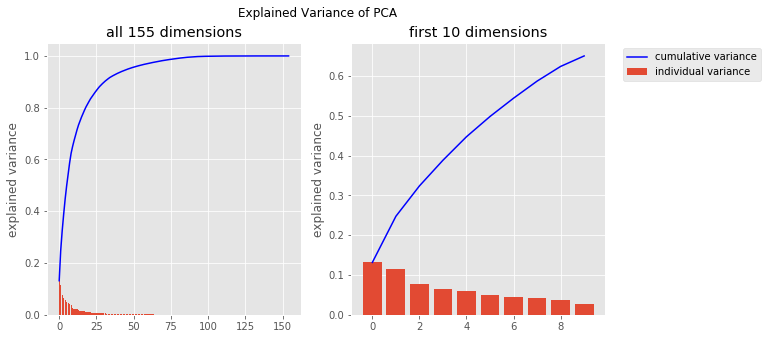

In [26]:
# look at PCA
from sklearn.decomposition import PCA
import seaborn as sns

# first split the data from the target
data_cols = list(imp_df)
data_cols.remove('readmitted')
data = imp_df[data_cols]
target = imp_df['readmitted']

# now do PCA on the data
pca = PCA(n_components=len(data_cols), random_state=1)
print('PCA model built!')

data_pca_fit = pca.fit_transform(data.copy())
#X_PCA = X_PCA_fit.transform(X)
explained_var = pca.explained_variance_ratio_
print("Orginal data dimension is {}. Embedded data dimension is {}".format(data.shape[-1], data_pca_fit.shape[-1]))
#print("cumulative explained variance : {}".format(np.cumsum(explained_var)))

fig = plt.figure(figsize = (10,5))
fig.suptitle('Explained Variance of PCA')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set(title='all {} dimensions'.format(len(data_cols)), ylabel='explained variance')
ax1.bar(np.arange(0,len(explained_var),1),explained_var)
ax1.plot(np.arange(0,len(explained_var),1), np.cumsum(explained_var), 'b-')
ax2.set(title='first 10 dimensions', ylabel='explained variance')
ax2.bar(np.arange(0,10,1),explained_var[:10])
ax2.plot(np.arange(0,10,1), np.cumsum(explained_var[:10]), 'b-')
ax2.legend(['cumulative variance', 'individual variance'], bbox_to_anchor=(1.05, 1))
plt.show()

[[  5.46835475e-01   8.01849699e-02   4.62458885e-01   3.32863659e-01]
 [  5.48813747e-01  -1.55821800e-01  -2.26212623e-01  -1.58004972e-01]
 [  5.11542977e-01  -7.02265590e-01   3.16730582e-02  -7.21587041e-03]
 [  5.22551339e-01   1.35803808e-01  -1.94046099e-01  -6.06131759e-01]
 [  5.43000320e-01  -3.17388066e-01   6.79316193e-04   3.39576014e-01]
 [  5.37042729e-01  -9.80991965e-03  -1.11478531e-01  -5.36134504e-03]
 [  5.78429098e-01   4.94847094e-01   2.48813714e-01   1.09044453e-01]
 [  4.91429895e-01   7.46644566e-02  -3.83794424e-01   5.02304668e-01]
 [  5.57225539e-01  -1.71599047e-01   6.04924137e-01  -2.19103383e-01]
 [  5.83658362e-01  -9.94436435e-02  -2.08542788e-01  -9.41936990e-03]]


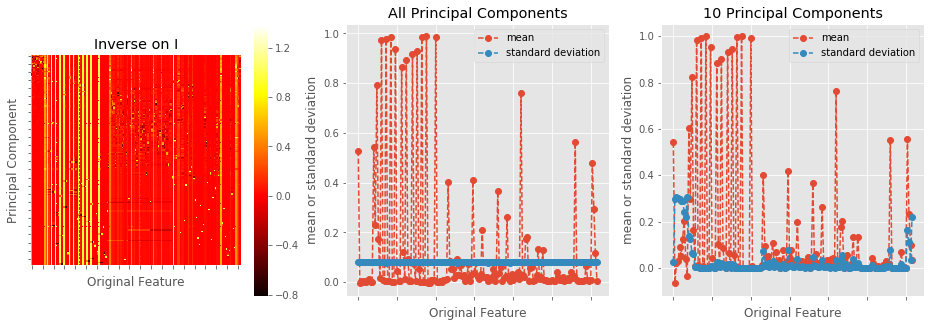

In [27]:
# now look at the features most contributing to the PCA

# this doesn't appear to be working as expected

#p_comp = [0]*data.shape[1]
#p_comp[0] = 1

inv_dat = pca.inverse_transform(np.eye(data.shape[1]))
#inv_dat = pca.inverse_transform(np.diag(p_comp))
mean = inv_dat.mean(axis=0)
std = inv_dat.std(axis=0)
print(inv_dat[:10,:4])

mean_10 = inv_dat[:][:10].mean(axis=0)
std_10 = inv_dat[:][:10].std(axis=0)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,5))

axes[0] = sns.heatmap(inv_dat, cmap="hot", cbar=True, ax=axes[0])
axes[0].set(xlabel='Original Feature', ylabel='Principal Component', yticklabels=[], xticklabels=[], title='Inverse on I',
           aspect='equal')

axes[1].plot(mean, '--o', label='mean')
axes[1].plot(std, '--o', label='standard deviation')
axes[1].set(xlabel='Original Feature', ylabel='mean or standard deviation', xticklabels=[], title='All Principal Components')
axes[1].legend()

axes[2].plot(mean_10, '--o', label='mean')
axes[2].plot(std_10, '--o', label='standard deviation')
axes[2].set(xlabel='Original Feature', ylabel='mean or standard deviation', xticklabels=[], title='10 Principal Components')
axes[2].legend()

plt.show()

In the above left plot we can see a heat map of the result from applying the inverse PCA transform on an identity matrix. In this plot we can see that some of the original features contributed much more than others. 

On the center plot we have averaged the contributions from the orignal features over the principal components. This give us information about how much the original feature contributed to all of the components. 

On the right plot we have averaged over the first 10 principal components. This tells us what original features contribued to the 10 principal components that contributed the most to the total variance in the original dataset.

for a threshold of 0.1 we keep 31 features


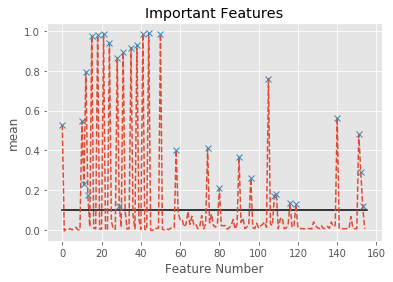

In [28]:
# not get the "most important" feautures from the original data
threshold = 0.1
ids = np.argwhere(mean > threshold)[:,0]
important_cols = [data_cols[i] for i in ids]
important_means = [mean[i] for i in ids]
print('for a threshold of {} we keep {} features'.format(threshold, len(important_cols)))
      
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Important Features')
ax.set_ylabel('mean')
ax.set_xlabel('Feature Number')
ax.plot([0,len(mean)], [threshold,threshold], 'k-', label = 'threshold')
ax.plot(mean, '--', label = 'mean')
ax.plot(ids, important_means, 'x')
plt.show()

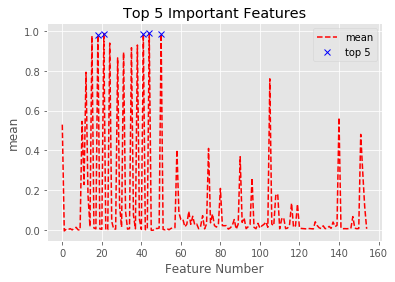

The top 5 most important features (in descending order) are 
1 = miglitol_category_No
2 = chlorpropamide_category_No
3 = acarbose_category_No
4 = glyburide-metformin_category_No
5 = nateglinide_category_No


In [29]:
# top 5
n_keep = 5
top_n_indices = sorted(range(len(mean)), key=lambda i: mean[i], reverse=True)[:n_keep]
top_n_means = [mean[i] for i in top_n_indices]
top_n_features = [data_cols[i] for i in top_n_indices]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Top {} Important Features'.format(n_keep))
ax.set_ylabel('mean')
ax.set_xlabel('Feature Number')
ax.plot(mean, 'r--', label = 'mean')
ax.plot(top_n_indices, top_n_means, 'bx', label='top {}'.format(n_keep))
ax.legend()
plt.show()

print('The top {} most important features (in descending order) are '.format(n_keep))
for j in range(n_keep):
    print('{} = {}'.format(j+1, top_n_features[j]))

Above we can see that we can find the "most important" features, or the features that contribute to the principal components the most. In this instance, we make a cut on the mean. We also find the 5 features that contribute the most. On a side note, these features are not at all what I would have expected.

<a id="phi_function"></a>
### Phi Functions

> One idea (__required for 7000 level students__): Implement two more phi functions: ReLU and SiLU (also called Swish). Compare their performance to the linear and sigmoid phi functions.

In [30]:
import math

class Linear:
    def val(x):
        return x
    def dev(x):
        return 1

class TANH:
    def val(x):
        return np.tanh(x)
    def dev(x):
        return 1 - np.tanh(x)*np.tanh(x)

class Sigmoid:
    def val(x):
        return 1 / (1 + np.exp(-x))
    def dev(x):
        return (1 / (1 + np.exp(-x))) * (1-1 / (1 + np.exp(-x)))

class Relu:    
    def val(x):
        return np.maximum(x.copy(),0)
    def dev(x):
        return (x>0).astype(int)

class ArcTan:    
    def val(x):
        return np.arctan(x)
    def dev(x):
        return 1/(x*x+1)
    
class SiLU:
    def val(x):
        return x / (1 + np.exp(-x))
    def dev(x):
        return x / (1 + np.exp(-x)) + (1-x / (1 + np.exp(-x))) / (1 + np.exp(-x))

    
def no_decay(eta,t,epoch):
    return eta

def exp_decay(eta,t,epoch):
    eta = 0.001
    k = 0.001
    lrate = eta * np.exp(-k*t)
    return lrate

def inverse_decay(eta,t,epoch):
    eta = 0.001
    lrate = eta /(1+t/epoch)
    return lrate

We can write the cost function in the following fashion

\begin{equation*}
\rm{cost}\_ \rm{function} = f_i \big( \phi_{i} (M_i \phi_{i-1}(M_{i-1} N_{i-2}+b_{i-1}) + b_i) \big)
\end{equation*}

where $f_i$ represents all the afterward layers and the cost function definition, $b_i$ is the bias term for the $i$-th layer, $N_i$ is the neuron value of the $i$-th layer, and $V_i$ is the value before apply the activation function($V_i = M_{i} N_{i-1}+b_{i}$). 

__Applying this we__ find that:

\begin{align*}
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial M_i} &= f_i ^{'}(N_{i}) \times \phi_{i}^{'}(V_i) \times N_{i-1} \\
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial b_i} &= f_i ^{'}(N_{i}) \times \phi_{i}^{'}(V_i) \\
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial M_{i-1}} &= f_i ^{'}(N_{i}) \times \phi_{i}^{'}(V_i) \times M_{i} \times \phi_{i-1}^{'}(V_{i-1}) \times N_{i-2} \\
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial b_{i-1}} &= f_i ^{'}(N_{i}) \times \phi_{i}^{'}(V_i) \times M_{i} \times \phi_{i-1}^{'}(V_{i-1})
\end{align*}

In principle we can also write the third equation as

\begin{equation*}
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial M_{i-1}} = f_{i-1} ^{'}(N_{i-1}) \times \phi_{i-1}^{'}(V_{i-1}) \times N_{i-2}
\end{equation*}

which gives us

\begin{equation*}
 f_{i-1} ^{'}(N_{i-1})= f_i ^{'}(N_{i}) \times \phi_{i}^{'}(V_i) \times M_{i}.
\end{equation*}

We can refer to $f_i ^{'}(N_{i})$ as the derivative_prefix. As long as we can keep track of the derivative_prefix in different layers, we can calculate the partial derivative of each layer efficiently.


In [60]:
from sklearn.metrics import confusion_matrix

class Sequential(object):
    def __init__(self, C=0.0, epochs=500, eta=0.001, random_state=None, 
                 cost_function='quadratic', 
                 metric='accuracy',
                 verbose=1,
                 regular='None',
                 learning_rate = no_decay,
                 early_stopping=False,
                 cost_matrix = None):
        np.random.seed(random_state)
        self.C = C
        self.epochs = epochs
        self.eta = eta
        self.cost_function = cost_function
        self.metric = metric
        self.verbose = verbose
        self.regular = regular
        self.early_stopping = early_stopping
        self.learning_rate = learning_rate
        self.cost_matrix=cost_matrix
        
        self.dims = []
        self.acts = []
        
        self.matrice = []
        self.bias = []
        self.vects = [] #before the activation function
        self.neurons = [] #after the activation function
        self.dropout = [] #to be implemented later
        self.Y = []
        
        self.loss = []
        
    def add(self,arg,argv):
        '''
        add('Dense',12)
        add('Dense',15)
        add('Activation',Sigmoid)
        add('Activation',Relu)
        add('Dropout',0.5)
        '''
        if arg == 'Dense':
            if len(self.dropout) < len(self.dims):
                self.dropout.append(0)
            if len(self.dims) == 0:
                self.dims.append([0,argv])
            else:
                self.dims.append([self.dims[-1][-1],argv])
        if arg == 'Activation':
            self.acts.append(argv)
        if arg == 'Dropout':
            self.dropout.append(argv)
        return
    
    @staticmethod
    def find_cost_metric(y_true, y_pred, cost_matrix):
        conf_matrix = confusion_matrix(y_true, y_pred)
        if cost_matrix is None:
            # check if the user passed a cost matrix
            print('No cost matrix passed, using ones')
            cost_matrix = np.ones(cost_matrix.shape)
        if (cost_matrix < 0).all():
            # make sure they are all positive
            cost_matrix = cost_matrix - np.min(cost_matrix)
        cost_matrix = cost_matrix/len(y_true) # normalize for bounds       
        return(np.sum(conf_matrix * cost_matrix))
    
    @staticmethod    
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_params(self,X,Y):
        for row,col in self.dims:
            W_num_elems = row*col
            W = np.random.uniform(-1.0, 1.0, size=W_num_elems)
            W = W.reshape(col, row) # reshape to be W
            self.matrice.append(W)
            
            b = np.random.uniform(-1.0, 1.0, size=col)
            b = b.reshape(col, 1)
            self.bias.append(b) #adding bias vector
        
        self.neurons.append(X.T)
        self.Y = self._encode_labels(Y)
        self.y_true = Y
        return
    
    def activate(self,vec,act):
        return act.val(vec)
    
    def activate_dev(self,vec,act):
        return act.dev(vec)
    
    def _feedforward(self):
        '''
        clear the previous feedforward result
        '''
        self.neurons = self.neurons[:1]
        self.vects = []
        for W,b,act in zip(self.matrice,self.bias,self.acts):
            self.vects.append(W @ self.neurons[-1] + b)
            self.neurons.append(self.activate(self.vects[-1],act))
        m = self.Y.shape[1]
        if self.cost_function == 'quadratic':
            self.loss.append(((self.neurons[-1]-self.Y)*(self.neurons[-1]-self.Y)).sum()/m)
        elif self.cost_function == 'cross_entropy':
            cost = -(1.0/m) * np.sum(self.Y*np.log(self.neurons[-1]) + (1-self.Y)*np.log(1-self.neurons[-1]))
            self.loss.append(cost)
        return

    def predict(self,X_test):
        neuron = X_test.T
        for W,b,act in zip(self.matrice,self.bias,self.acts):
            vec = W @ neuron + b
            neuron = self.activate(vec,act)
        y_pred = np.argmax(neuron, axis=0)
        return y_pred

    def set_init_dev_prefix(self):
        if self.cost_function == 'quadratic':
            return -2 * (self.Y - self.neurons[-1])
        if self.cost_function == 'cross_entropy':
            return -(self.Y - self.neurons[-1])

    def _update_params(self):
        cur_dev_prefix = self.set_init_dev_prefix()
        grads = []
        bias_grads = []
        for N,N1,V,act,W in zip(self.neurons[1:][::-1],self.neurons[:-1][::-1],self.vects[::-1],self.acts[::-1],self.matrice[::-1]):
            cur_dev_prefix *= self.activate_dev(V,act)
            grads.append(cur_dev_prefix @ N1.T)
            bias_grads.append(cur_dev_prefix @ np.full((cur_dev_prefix.shape[1], 1), 1))
            cur_dev_prefix = W.T @ cur_dev_prefix                
        grads.reverse()
        bias_grads.reverse()
        
        if self.regular != 'None':
            for W,b,grad,bias_grad in zip(self.matrice,self.bias,grads,bias_grads):
                if 'L2' in self.regular:
                    grad += 2*self.C * W
                    bias_grad += 2*self.C * b
                if 'L1' in self.regular:
                    grad += ((W>0).astype(int)-0.5)*(2*self.C)
                    bias_grad += self.C *((b>0).astype(int)-0.5)*(2*self.C)
                    
        for W,grad,b,bias_grad in zip(self.matrice,grads,self.bias,bias_grads):
            W -= self.eta * grad
            b -= self.eta * bias_grad
        return
    
    def fit(self,X,Y):
        self.dims[0][0] = X.shape[1]
        if len(np.unique(Y)) != self.dims[-1][-1]:
            print('Error: output dimension is wrong!')
            return False
        self._initialize_params(X,Y)
        #print(self.dims)
        #print([x.shape for x in self.matrice])
        #print([x.shape for x in self.bias])

        for i in range(self.epochs):
            self.eta = self.learning_rate(self.eta,i,self.epochs)
            self._feedforward()
            self._update_params()
            
            if self.verbose and not i % max(1,int(self.epochs/10)):
                if self.metric == 'accuracy':
                    accu = accuracy_score(np.argmax(self.neurons[-1], axis=0),Y)
                if self.metric == 'custom':
                    if self.cost_matrix.all() == None:
                        print('Initialize with a cost matrix, likely a better way to do this?')
                    accu = self.find_cost_metric(Y, np.argmax(self.neurons[-1], axis=0), self.cost_matrix)
                print('{} percent finished, current metric is {:.3f}.'.format(100*i//self.epochs,accu))
        plt.figure()
        plt.plot([i for i in range(self.epochs-1)],self.loss[1:])
        plt.xlabel('Epoch number')
        plt.ylabel('Loss')
        print('Training is done!')

In [62]:
%matplotlib inline
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

my_cost_matrix = np.array([[1,  10, 10],
                           [5,  0,  3],
                           [5,  3,  0]])

model = Sequential(C=0.1, epochs=5000, eta=0.01, random_state=42, 
                 cost_function='cross_entropy', 
                 metric='custom',
                 verbose=1,
                 regular='L1',
                 learning_rate=inverse_decay)
#                 cost_matrix=my_cost_matrix)
model.add('Dense',3)
model.add('Activation',Sigmoid)
model.add('Dense',20)
model.add('Activation',Sigmoid)
model.add('Dense',28)
model.add('Activation',Sigmoid)
model.add('Dense',3)
model.add('Activation',Sigmoid)

ds = load_iris()
X = ds.data
X_test = StandardScaler().fit(X).transform(X)
X = StandardScaler().fit(X).transform(X)
Y = ds.target # note problem is NOT binary anymore, there are three classes!


model.fit(X,Y)
#print(model.predict(X))
#print(Y)

AttributeError: 'NoneType' object has no attribute 'all'

In [59]:
test_test = np.array([[1,1,1],[1,0,1],[1,-1,1]])
(test_test<0).all()
test_l = None
print(str(type(test_l)))

<class 'NoneType'>


In [ ]:
full_df = pd.read_csv('data/processed_data.csv')

Y = full_df['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values
data_cols = list(full_df)
data_cols.remove('readmitted')
X = full_df[data_cols].values

model = Sequential(C=0.1, epochs=100, eta=0.01, random_state=42, 
                 cost_function='cross_entropy', 
                 metric='accuracy',
                 verbose=1,
                 regular='None',
                 learning_rate=exp_decay)
model.add('Dense',3)
model.add('Activation',Sigmoid)
model.add('Dense',20)
model.add('Activation',Sigmoid)
model.add('Dense',28)
model.add('Activation',Sigmoid)
model.add('Dense',3)
model.add('Activation',Sigmoid)



model.fit(X,Y)
print(model.predict(X))
print(Y)

In [ ]:
from sklearn.datasets import load_digits

ds = load_digits()
X = ds.data/16.0-0.5
Y = ds.target

model = Sequential(C=0.1, epochs=1000, eta=0.001, random_state=42, 
                 cost_function='cross_entropy', 
                 metric='accuracy',
                 verbose=1,
                 regular='L1',
                 learning_rate=no_decay)
model.add('Dense',30)
model.add('Activation',Sigmoid)
model.add('Dense',10)
model.add('Activation',Sigmoid)



model.fit(X,Y)

print(model.predict(X))

<a id="thoughts"></a>
## Final Thoughts

- We may be able to reduce the number of features be combining all of the medication columns into two features, the number of changes in medications and a second column containg the total number of medications taken by the patient. 

- We could also potentially reduce the dimensionality of our problem by combining the admission ids into groups. For instance admission source ids 1 (Emergency), 2 (Urgend), and 7 (Trauma Center) are all non-elective. Reducing the number of categories here would reduce the number of features afer one hot encoding.

- We may be able to make use of the HbA1c results by combining this column with the max glucose serum column. We could combine these into high, normal, low, and (potentially) not measured. Although the two individual columns were dropped because they didn't contain enough data, the combined result may have enough data to be used.

- We kept each individual result from patients who were included in the dataset multiple times (we kept rows with the same patient id). If we were to collapse these into a single column we would have to think about how to combine multiple stays. For example, the stay length could be the average of the stay lenghts for each individual encounter. Doing this would slightly change the question we want to answer with this project. By combining we could answer "how likely is a patient to be readmitted". This __more__